# 1. 背景与挖掘目标

- 项目为《Python 数据分析与挖掘实战》第 13 章：财政收入影响因素分析及预测模型，内容参考了书中源代码及 u012063773 的博客
- 挖掘目标为分析地方财政收入的关键特征，筛选特征进行分析建模，然后对财政收入进行预测

# 2. 分析方法与过程

## 2.1 数据探索

1. 主要变量描述性分析：可以看出 y 的波动很大

In [1]:
'''原始数据概括性度量'''
import numpy as np
import pandas as pd

inputfile = 'chapter13/demo/data/data1.csv'
data = pd.read_csv(inputfile)
r = [data.min(), data.max(), data.mean(), data.std()]
r = pd.DataFrame(r, index=['Min', 'Max', 'Mean', 'STD']).T
r = np.round(r, 2)    # 保留两位小数
r

,Min,Max,Mean,STD
x1,3831732.00,7599295.00,5579519.95,1262194.72
x2,181.54,2110.78,765.04,595.70
x3,448.19,6882.85,2370.83,1919.17
x4,7571.00,42049.14,19644.69,10203.02
x5,6212.70,33156.83,15870.95,8199.77
x6,6370241.00,8323096.00,7350513.60,621341.85
x7,525.71,4454.55,1712.24,1184.71
x8,985.31,15420.14,5705.80,4478.40
x9,60.62,228.46,129.49,50.51
x10,65.66,852.56,340.22,251.58


2. 原始数据相关性分析：可以看出 x11 与 y 相关性不大，且为负相关

In [2]:
'''原始数据求解 Pearson 相关系数'''
pear = np.round(data.corr(method = 'pearson'), 2)
pear

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
x1,1.00,0.95,0.95,0.97,0.97,0.99,0.95,0.97,0.98,0.98,-0.29,0.94,0.96,0.94
x2,0.95,1.00,1.00,0.99,0.99,0.92,0.99,0.99,0.98,0.98,-0.13,0.89,1.00,0.98
x3,0.95,1.00,1.00,0.99,0.99,0.92,1.00,0.99,0.98,0.99,-0.15,0.89,1.00,0.99
x4,0.97,0.99,0.99,1.00,1.00,0.95,0.99,1.00,0.99,1.00,-0.19,0.91,1.00,0.99
x5,0.97,0.99,0.99,1.00,1.00,0.95,0.99,1.00,0.99,1.00,-0.18,0.90,0.99,0.99
x6,0.99,0.92,0.92,0.95,0.95,1.00,0.93,0.95,0.97,0.96,-0.34,0.95,0.94,0.91
x7,0.95,0.99,1.00,0.99,0.99,0.93,1.00,0.99,0.98,0.99,-0.15,0.89,1.00,0.99
x8,0.97,0.99,0.99,1.00,1.00,0.95,0.99,1.00,0.99,1.00,-0.15,0.90,1.00,0.99
x9,0.98,0.98,0.98,0.99,0.99,0.97,0.98,0.99,1.00,0.99,-0.23,0.91,0.99,0.98
x10,0.98,0.98,0.99,1.00,1.00,0.96,0.99,1.00,0.99,1.00,-0.17,0.90,0.99,0.99


## 2.2 模型构建

1. Lasso 变量选择模型

In [46]:
'''Lasson 变量选择'''
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1, max_iter=100000)
model.fit(data.iloc[:, 0:13], data['y'])
print(model.coef_)

[-3.88351082e-04 -5.85234238e-01  4.38483025e-01 -1.25563758e-01
  1.74517446e-01  8.19661325e-04  2.67660850e-01  2.89486267e-02
 -7.55994563e+00 -8.62534215e-02  3.37878229e+00  0.00000000e+00
 -7.70629587e-03]


备注：书中使用的是 Adaptive-Lasso 变量选择，这个函数多处查找都没找到，因此直接使用 Lasso，得到的结果和书中略有不同，后面保留的变量暂时以书中的为准

2. 财政收入及各类别收入预测模型：各类别收入预测方法一样，因此以财政收入为例，描述灰色模型的计算过程，然后建立灰色预测与神经网络的组合预测模型，参数设置为误差精度10^-7，学习次数 10000 次，神经元个数为 6 个

- 灰色预测原理
$灰色预测对原始数据进行生成处理如累加，生成有较强规律性的数据序列，然后建立相应的微分方程模型，从而预测事物未来发展趋势的状况。$
$设变量 X^{(0)} = \{X^{(0)}(i), i=1,2\dots n\} 为一非负单调原始数据数列，对X^{(0)} 进行 1 次累加得到 X^{(1)} = \{X^{(1)}(k), k=1,2\dots n\}$
$对 X^{(1)} 建立一阶线性微分方程，其中 a, u 为常数$
$$\frac{dX^{(1)}}{dt} + aX^{(1)} = u$$
$求解微分方程，得到$
$$X^{(1)}(t) = [\int e^{\int a\cdot dx} \cdot u \cdot dx+ C] \cdot \int e^{\int -a\cdot dx}\text {………………（1）}$$
$$\implies X^{(1)}(t) = (\frac {u}{a} \cdot e^{at} + C) \cdot e^{-at}\text {………………（2）}$$
$将 X^{(1)}(t_0) 代入（2），求解 C，得到$：
$$C = (X^{(1)}(t_0) - \frac{u}{a}) \cdot e^{-at_0}\text {………………（3）}$$
$将（3）代入（2），得到$：
$$X^{(1)}(t) = [X^{(1)}(t_0) - \frac{u}{a}]\cdot e^{-a(t-t_0)} + \frac{u}{a}\text {………………（4）}$$
$对于离散值：$
$$X^{(1)}(k+1) = [X^{(1)}(1) - \frac{u}{a}]\cdot e^{-ak} + \frac{u}{a}\text {………………（5）}$$
$灰色预测中对于 a, u 的求解使用的是最小二乘法。由于：$
$$X^{(1)}(k) - X^{(1)}(k-1) =  \frac{\Delta X^{(1)}(k)}{\Delta k} = X^{(0)}(k), \Delta k = 1\text {………………（6）}$$
$将（6） 代入微分方程，得到：$
$$X^{(0)}(k) = -aX^{(1)}(k)+u \text {………………（7）}$$
$由于\frac{\Delta X^{(1)}(k)}{\Delta k}涉及X^{(1)}(k) 两个时刻的值，因此将（7）中的X^{(1)}(k)换为两个时刻的均值更为合理，得到：$
$$ Y = BU $$
$即：$
$$      \begin{bmatrix}
        X^{(0)}(2)\\
        X^{(0)}(3)\\
        \vdots\\
        X^{(0)}(N)\\
        \end{bmatrix}
  =   
        \begin{bmatrix}
        -\frac{1}{2}(X^{(1)}(2) + X^{(1)}(1)) & 1 \\
        -\frac{1}{2}(X^{(1)}(3) + X^{(1)}(2)) & 1 \\
        \vdots & \vdots \\
        -\frac{1}{2}(X^{(1)}(N) + X^{(1)}(N-1)) & 1 \\
        \end{bmatrix}
        \begin{bmatrix}
        a \\
        u \\
        \end{bmatrix}\text {………………（8）}$$
$由最小二乘法，得到：$
$$ \hat{U} 
   =  
   \begin{bmatrix}
   \hat{a} \\
   \hat{u} \\
   \end{bmatrix}
   = (B^TB)^{-1}B^TY\text {………………（9）}$$
$将（9）代入（5），得到：$
$$ X^{(1)}(k+1) = [X^{(1)}(1) - \frac{\hat{u}}{\hat{a}}]\cdot e^{-\hat{a}k} + \frac{\hat u}{\hat a}\text {………………（10）} $$
$将（10）代入（6）：$
$$ X^{(0)}(k+1) = (1-e^{\hat{a}})[X^{(0)}(1) - \frac{\hat{u}}{\hat{a}}]e^{-\hat{a}k}\text {………………（11）} $$

In [1]:
'''灰色预测函数'''
def GM11(x0): #自定义灰色预测函数
    import numpy as np
    x1 = x0.cumsum() # 生成累加序列
    z1 = (x1[:len(x1)-1] + x1[1:])/2.0 # 生成紧邻均值（MEAN）序列，比直接使用累加序列好，共 n-1 个值
    z1 = z1.reshape((len(z1),1))
    B = np.append(-z1, np.ones_like(z1), axis = 1)    # 生成 B 矩阵
    Y = x0[1:].reshape((len(x0)-1, 1))    # Y 矩阵
    [[a],[u]] = np.dot(np.dot(np.linalg.inv(np.dot(B.T, B)), B.T), Y) #计算参数
    f = lambda k: (x0[0]-u/a)*np.exp(-a*(k-1))-(x0[0]-u/a)*np.exp(-a*(k-2)) #还原值
    delta = np.abs(x0 - np.array([f(i) for i in range(1,len(x0)+1)]))    # 计算残差
    C = delta.std()/x0.std()
    P = 1.0*(np.abs(delta - delta.mean()) < 0.6745*x0.std()).sum()/len(x0)
    return f, a, u, x0[0], C, P #返回灰色预测函数、a、b、首项、方差比、小残差概率

In [2]:
'''地方财政收入灰色预测'''
import numpy as np
import pandas as pd

inputfile = 'chapter13/demo/data/data1.csv'
outputfile = 'chapter13/demo/tmp2/data1_GM11.xls'
modelfile = 'chapter13/demo/tmp2/net.model'
data = pd.read_csv(inputfile)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,3831732,181.54,448.19,7571.00,6212.70,6370241,525.71,985.31,60.62,65.66,120.0,1.029,5321,64.87
1,3913824,214.63,549.97,9038.16,7601.73,6467115,618.25,1259.20,73.46,95.46,113.5,1.051,6529,99.75
2,3928907,239.56,686.44,9905.31,8092.82,6560508,638.94,1468.06,81.16,81.16,108.2,1.064,7008,88.11
3,4282130,261.58,802.59,10444.60,8767.98,6664862,656.58,1678.12,85.72,91.70,102.2,1.092,7694,106.07
4,4453911,283.14,904.57,11255.70,9422.33,6741400,758.83,1893.52,88.88,114.61,97.7,1.200,8027,137.32


In [3]:
data.index = range(1994, 2014)
data.loc[2014] = None
data.loc[2015] = None

In [4]:
# 模型精度评价
l = ['x1', 'x2', 'x3', 'x4', 'x5', 'x7']
for i in l:
    GM = GM11(data[i][list(range(1994, 2014))].values)
    f = GM[0]
    c = GM[-2]
    p = GM[-1]
    data[i][2014] = f(len(data)-1)
    data[i][2015] = f(len(data))
    data[i] = data[i].round(2)
    if (c < 0.35) & (p > 0.95):
        print('对于模型{}，该模型精度为---好'.format(i))
    elif (c < 0.5) & (p > 0.8):
        print('对于模型{}，该模型精度为---合格'.format(i))
    elif (c < 0.65) & (p > 0.7):
        print('对于模型{}，该模型精度为---勉强合格'.format(i))
    else:
        print('对于模型{}，该模型精度为---不合格'.format(i))

data[l+['y']].to_excel(outputfile, )

对于模型x1，该模型精度为---好
对于模型x2，该模型精度为---好
对于模型x3，该模型精度为---好
对于模型x4，该模型精度为---好
对于模型x5，该模型精度为---好
对于模型x7，该模型精度为---好


In [16]:
'''神经网络'''
inputfile2 = outputfile
outputfile2 = 'chapter13/demo/tmp2/revenue.xls'
modelfile = 'chapter13/demo/tmp2/1-net.model'
data2 = pd.read_excel(inputfile2, index_col=0)
data2

,x1,x2,x3,x4,x5,x7,y
1994,3831732.00,181.54,448.19,7571.00,6212.70,525.71,64.87
1995,3913824.00,214.63,549.97,9038.16,7601.73,618.25,99.75
1996,3928907.00,239.56,686.44,9905.31,8092.82,638.94,88.11
1997,4282130.00,261.58,802.59,10444.60,8767.98,656.58,106.07
1998,4453911.00,283.14,904.57,11255.70,9422.33,758.83,137.32
1999,4548852.00,308.58,1000.69,12018.52,9751.44,878.26,188.14
2000,4962579.00,348.09,1121.13,13966.53,11349.47,923.67,219.91
2001,5029338.00,387.81,1248.29,14694.00,11467.35,978.21,271.91
2002,5070216.00,453.49,1370.68,13380.47,10671.78,1009.24,269.10
2003,5210706.00,533.55,1494.27,15002.59,11570.58,1175.17,300.55


In [17]:
feature = list(data2.columns[:len(data2.columns)-1])
train = data2.loc[list(range(1994, 2014))].copy()
mean = train.mean()
std = train.std() 
train = (train - mean) / std    # 数据标准化，这里使用标准差标准化
x_train = train[feature].values
y_train = train['y'].values

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

model = Sequential()
model.add(Dense(input_dim=6, units=12))
model.add(Activation('relu'))
model.add(Dense(input_dim=12, units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10000, batch_size=16)
model.save_weights(modelfile2)

Epoch 1/10000
20/20 [==============================] - 0s 3ms/step - loss: 1.1308
Epoch 2/10000
20/20 [==============================] - 0s 86us/step - loss: 1.0946
Epoch 3/10000
20/20 [==============================] - 0s 94us/step - loss: 1.0544
Epoch 4/10000
20/20 [==============================] - 0s 78us/step - loss: 1.0260
Epoch 5/10000
20/20 [==============================] - 0s 102us/step - loss: 0.9978
Epoch 6/10000
20/20 [==============================] - 0s 148us/step - loss: 0.9754
Epoch 7/10000
20/20 [==============================] - 0s 112us/step - loss: 0.9541
Epoch 8/10000
20/20 [==============================] - 0s 131us/step - loss: 0.9325
Epoch 9/10000
20/20 [==============================] - 0s 131us/step - loss: 0.9151
Epoch 10/10000
20/20 [==============================] - 0s 123us/step - loss: 0.8984
Epoch 11/10000
20/20 [==============================] - 0s 87us/step - loss: 0.8831
Epoch 12/10000
20/20 [==============================] - 0s 81us/step - loss: 0.8

20/20 [==============================] - 0s 67us/step - loss: 0.0277
Epoch 194/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0273
Epoch 195/10000
20/20 [==============================] - 0s 74us/step - loss: 0.0270
Epoch 196/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0266
Epoch 197/10000
20/20 [==============================] - 0s 130us/step - loss: 0.0264
Epoch 198/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0260
Epoch 199/10000
20/20 [==============================] - 0s 65us/step - loss: 0.0258
Epoch 200/10000
20/20 [==============================] - 0s 67us/step - loss: 0.0255
Epoch 201/10000
20/20 [==============================] - 0s 67us/step - loss: 0.0252
Epoch 202/10000
20/20 [==============================] - ETA: 0s - loss: 0.011 - 0s 65us/step - loss: 0.0249
Epoch 203/10000
20/20 [==============================] - 0s 64us/step - loss: 0.0248
Epoch 204/10000
20/20 [==============================] -

20/20 [==============================] - 0s 71us/step - loss: 0.0114
Epoch 385/10000
20/20 [==============================] - 0s 88us/step - loss: 0.0112
Epoch 386/10000
20/20 [==============================] - 0s 77us/step - loss: 0.0112
Epoch 387/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0112
Epoch 388/10000
20/20 [==============================] - 0s 78us/step - loss: 0.0112
Epoch 389/10000
20/20 [==============================] - 0s 77us/step - loss: 0.0112
Epoch 390/10000
20/20 [==============================] - 0s 78us/step - loss: 0.0111
Epoch 391/10000
20/20 [==============================] - 0s 70us/step - loss: 0.0111
Epoch 392/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0111
Epoch 393/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0111
Epoch 394/10000
20/20 [==============================] - 0s 78us/step - loss: 0.0111
Epoch 395/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0

Epoch 480/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0103
Epoch 481/10000
20/20 [==============================] - 0s 79us/step - loss: 0.0102
Epoch 482/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0103
Epoch 483/10000
20/20 [==============================] - 0s 68us/step - loss: 0.0102
Epoch 484/10000
20/20 [==============================] - 0s 128us/step - loss: 0.0102
Epoch 485/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0101
Epoch 486/10000
20/20 [==============================] - 0s 138us/step - loss: 0.0102
Epoch 487/10000
20/20 [==============================] - 0s 70us/step - loss: 0.0101
Epoch 488/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0101
Epoch 489/10000
20/20 [==============================] - 0s 82us/step - loss: 0.0099
Epoch 490/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0099
Epoch 491/10000
20/20 [==============================] - 0s 72u

20/20 [==============================] - 0s 82us/step - loss: 0.0081
Epoch 673/10000
20/20 [==============================] - 0s 78us/step - loss: 0.0080
Epoch 674/10000
20/20 [==============================] - 0s 81us/step - loss: 0.0079
Epoch 675/10000
20/20 [==============================] - 0s 75us/step - loss: 0.0079
Epoch 676/10000
20/20 [==============================] - 0s 67us/step - loss: 0.0078
Epoch 677/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0079
Epoch 678/10000
20/20 [==============================] - 0s 82us/step - loss: 0.0078
Epoch 679/10000
20/20 [==============================] - 0s 74us/step - loss: 0.0077
Epoch 680/10000
20/20 [==============================] - 0s 78us/step - loss: 0.0077
Epoch 681/10000
20/20 [==============================] - 0s 77us/step - loss: 0.0076
Epoch 682/10000
20/20 [==============================] - ETA: 0s - loss: 0.005 - 0s 67us/step - loss: 0.0076
Epoch 683/10000
20/20 [==============================] - 

Epoch 863/10000
20/20 [==============================] - 0s 78us/step - loss: 0.0067
Epoch 864/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0067
Epoch 865/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0066
Epoch 866/10000
20/20 [==============================] - 0s 74us/step - loss: 0.0066
Epoch 867/10000
20/20 [==============================] - 0s 70us/step - loss: 0.0065
Epoch 868/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0065
Epoch 869/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0065
Epoch 870/10000
20/20 [==============================] - 0s 85us/step - loss: 0.0065
Epoch 871/10000
20/20 [==============================] - 0s 70us/step - loss: 0.0065
Epoch 872/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0067
Epoch 873/10000
20/20 [==============================] - 0s 75us/step - loss: 0.0066
Epoch 874/10000
20/20 [==============================] - 0s 78us/

20/20 [==============================] - 0s 67us/step - loss: 0.0061
Epoch 960/10000
20/20 [==============================] - 0s 68us/step - loss: 0.0060
Epoch 961/10000
20/20 [==============================] - 0s 81us/step - loss: 0.0060
Epoch 962/10000
20/20 [==============================] - 0s 70us/step - loss: 0.0061
Epoch 963/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0062
Epoch 964/10000
20/20 [==============================] - 0s 90us/step - loss: 0.0063
Epoch 965/10000
20/20 [==============================] - 0s 68us/step - loss: 0.0063
Epoch 966/10000
20/20 [==============================] - 0s 69us/step - loss: 0.0062
Epoch 967/10000
20/20 [==============================] - 0s 69us/step - loss: 0.0061
Epoch 968/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0061
Epoch 969/10000
20/20 [==============================] - 0s 67us/step - loss: 0.0062
Epoch 970/10000
20/20 [==============================] - 0s 80us/step - loss: 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - 0s 73us/step - loss: 0.0032
Epoch 1884/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0031
Epoch 1885/10000
20/20 [==============================] - 0s 67us/step - loss: 0.0031
Epoch 1886/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0032
Epoch 1887/10000
20/20 [==============================] - 0s 80us/step - loss: 0.0032
Epoch 1888/10000
20/20 [==============================] - 0s 79us/step - loss: 0.0031
Epoch 1889/10000
20/20 [==============================] - 0s 65us/step - loss: 0.0031
Epoch 1890/10000
20/20 [==============================] - 0s 77us/step - loss: 0.0032
Epoch 1891/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0031
Epoch 1892/10000
20/20 [==============================] - 0s 79us/step - loss: 0.0031
Epoch 1893/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0033
Epoch 1894/10000
20/20 [==============================] - 0s 77us/step 

20/20 [==============================] - 0s 74us/step - loss: 0.0033
Epoch 1979/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0031
Epoch 1980/10000
20/20 [==============================] - 0s 68us/step - loss: 0.0031
Epoch 1981/10000
20/20 [==============================] - 0s 69us/step - loss: 0.0031
Epoch 1982/10000
20/20 [==============================] - 0s 68us/step - loss: 0.0031
Epoch 1983/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0030
Epoch 1984/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0030
Epoch 1985/10000
20/20 [==============================] - 0s 77us/step - loss: 0.0030
Epoch 1986/10000
20/20 [==============================] - 0s 97us/step - loss: 0.0030
Epoch 1987/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0029
Epoch 1988/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0030
Epoch 1989/10000
20/20 [==============================] - 0s 79us/step 

20/20 [==============================] - 0s 71us/step - loss: 0.0028
Epoch 2074/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0028
Epoch 2075/10000
20/20 [==============================] - 0s 75us/step - loss: 0.0027
Epoch 2076/10000
20/20 [==============================] - 0s 77us/step - loss: 0.0027
Epoch 2077/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0028
Epoch 2078/10000
20/20 [==============================] - 0s 79us/step - loss: 0.0032
Epoch 2079/10000
20/20 [==============================] - 0s 70us/step - loss: 0.0034
Epoch 2080/10000
20/20 [==============================] - 0s 70us/step - loss: 0.0035
Epoch 2081/10000
20/20 [==============================] - 0s 88us/step - loss: 0.0038
Epoch 2082/10000
20/20 [==============================] - 0s 70us/step - loss: 0.0037
Epoch 2083/10000
20/20 [==============================] - 0s 79us/step - loss: 0.0036
Epoch 2084/10000
20/20 [==============================] - 0s 102us/step

20/20 [==============================] - 0s 75us/step - loss: 0.0024
Epoch 2263/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0025
Epoch 2264/10000
20/20 [==============================] - 0s 68us/step - loss: 0.0024
Epoch 2265/10000
20/20 [==============================] - 0s 67us/step - loss: 0.0024
Epoch 2266/10000
20/20 [==============================] - 0s 68us/step - loss: 0.0024
Epoch 2267/10000
20/20 [==============================] - 0s 74us/step - loss: 0.0024
Epoch 2268/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0025
Epoch 2269/10000
20/20 [==============================] - 0s 78us/step - loss: 0.0025
Epoch 2270/10000
20/20 [==============================] - 0s 74us/step - loss: 0.0024
Epoch 2271/10000
20/20 [==============================] - 0s 68us/step - loss: 0.0024
Epoch 2272/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0025
Epoch 2273/10000
20/20 [==============================] - 0s 72us/step 

20/20 [==============================] - 0s 73us/step - loss: 0.0021
Epoch 2453/10000
20/20 [==============================] - 0s 74us/step - loss: 0.0022
Epoch 2454/10000
20/20 [==============================] - 0s 77us/step - loss: 0.0022
Epoch 2455/10000
20/20 [==============================] - 0s 75us/step - loss: 0.0022
Epoch 2456/10000
20/20 [==============================] - 0s 69us/step - loss: 0.0021
Epoch 2457/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0021
Epoch 2458/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0021
Epoch 2459/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0021
Epoch 2460/10000
20/20 [==============================] - 0s 74us/step - loss: 0.0021
Epoch 2461/10000
20/20 [==============================] - 0s 75us/step - loss: 0.0022
Epoch 2462/10000
20/20 [==============================] - 0s 83us/step - loss: 0.0021
Epoch 2463/10000
20/20 [==============================] - 0s 76us/step 

20/20 [==============================] - 0s 87us/step - loss: 0.0018
Epoch 2641/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0019
Epoch 2642/10000
20/20 [==============================] - 0s 79us/step - loss: 0.0019
Epoch 2643/10000
20/20 [==============================] - 0s 74us/step - loss: 0.0019
Epoch 2644/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0019
Epoch 2645/10000
20/20 [==============================] - ETA: 0s - loss: 0.001 - 0s 66us/step - loss: 0.0019
Epoch 2646/10000
20/20 [==============================] - 0s 68us/step - loss: 0.0018
Epoch 2647/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0018
Epoch 2648/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0019
Epoch 2649/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0019
Epoch 2650/10000
20/20 [==============================] - 0s 74us/step - loss: 0.0019
Epoch 2651/10000
20/20 [=======================

20/20 [==============================] - 0s 72us/step - loss: 0.0017
Epoch 2829/10000
20/20 [==============================] - 0s 73us/step - loss: 0.0017
Epoch 2830/10000
20/20 [==============================] - 0s 77us/step - loss: 0.0016
Epoch 2831/10000
20/20 [==============================] - ETA: 0s - loss: 0.001 - 0s 65us/step - loss: 0.0016
Epoch 2832/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0017
Epoch 2833/10000
20/20 [==============================] - 0s 77us/step - loss: 0.0018
Epoch 2834/10000
20/20 [==============================] - 0s 72us/step - loss: 0.0020
Epoch 2835/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0019
Epoch 2836/10000
20/20 [==============================] - 0s 75us/step - loss: 0.0016
Epoch 2837/10000
20/20 [==============================] - 0s 69us/step - loss: 0.0016
Epoch 2838/10000
20/20 [==============================] - 0s 76us/step - loss: 0.0016
Epoch 2839/10000
20/20 [=======================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - 0s 68us/step - loss: 7.8643e-04
Epoch 3749/10000
20/20 [==============================] - 0s 70us/step - loss: 8.0585e-04
Epoch 3750/10000
20/20 [==============================] - 0s 75us/step - loss: 8.2792e-04
Epoch 3751/10000
20/20 [==============================] - 0s 67us/step - loss: 8.1207e-04
Epoch 3752/10000
20/20 [==============================] - 0s 75us/step - loss: 8.1016e-04
Epoch 3753/10000
20/20 [==============================] - 0s 70us/step - loss: 8.1428e-04
Epoch 3754/10000
20/20 [==============================] - 0s 71us/step - loss: 8.5730e-04
Epoch 3755/10000
20/20 [==============================] - 0s 77us/step - loss: 8.8500e-04
Epoch 3756/10000
20/20 [==============================] - 0s 82us/step - loss: 8.2050e-04
Epoch 3757/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5305e-04
Epoch 3758/10000
20/20 [==============================] - 0s 71us/step - loss: 8.0207e-04
Epoch 3759/10000
20/20 [===

20/20 [==============================] - 0s 69us/step - loss: 0.0012
Epoch 3929/10000
20/20 [==============================] - 0s 71us/step - loss: 0.0011
Epoch 3930/10000
20/20 [==============================] - 0s 71us/step - loss: 7.7514e-04
Epoch 3931/10000
20/20 [==============================] - 0s 74us/step - loss: 7.7845e-04
Epoch 3932/10000
20/20 [==============================] - 0s 76us/step - loss: 9.8458e-04
Epoch 3933/10000
20/20 [==============================] - 0s 75us/step - loss: 0.0010
Epoch 3934/10000
20/20 [==============================] - 0s 78us/step - loss: 9.7660e-04
Epoch 3935/10000
20/20 [==============================] - 0s 96us/step - loss: 9.0001e-04
Epoch 3936/10000
20/20 [==============================] - 0s 72us/step - loss: 8.2046e-04
Epoch 3937/10000
20/20 [==============================] - 0s 68us/step - loss: 8.0413e-04
Epoch 3938/10000
20/20 [==============================] - 0s 66us/step - loss: 7.7525e-04
Epoch 3939/10000
20/20 [===============

20/20 [==============================] - 0s 66us/step - loss: 8.0177e-04
Epoch 4020/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5934e-04
Epoch 4021/10000
20/20 [==============================] - 0s 78us/step - loss: 7.9280e-04
Epoch 4022/10000
20/20 [==============================] - 0s 68us/step - loss: 7.7237e-04
Epoch 4023/10000
20/20 [==============================] - 0s 75us/step - loss: 6.7476e-04
Epoch 4024/10000
20/20 [==============================] - 0s 72us/step - loss: 7.2475e-04
Epoch 4025/10000
20/20 [==============================] - 0s 225us/step - loss: 6.6868e-04
Epoch 4026/10000
20/20 [==============================] - 0s 70us/step - loss: 6.2563e-04
Epoch 4027/10000
20/20 [==============================] - 0s 77us/step - loss: 8.1120e-04
Epoch 4028/10000
20/20 [==============================] - 0s 68us/step - loss: 8.1223e-04
Epoch 4029/10000
20/20 [==============================] - 0s 79us/step - loss: 6.8251e-04
Epoch 4030/10000
20/20 [==

Epoch 4200/10000
20/20 [==============================] - 0s 74us/step - loss: 5.5691e-04
Epoch 4201/10000
20/20 [==============================] - 0s 67us/step - loss: 5.8362e-04
Epoch 4202/10000
20/20 [==============================] - 0s 73us/step - loss: 6.0329e-04
Epoch 4203/10000
20/20 [==============================] - 0s 72us/step - loss: 6.1528e-04
Epoch 4204/10000
20/20 [==============================] - 0s 76us/step - loss: 5.5040e-04
Epoch 4205/10000
20/20 [==============================] - 0s 70us/step - loss: 6.3690e-04
Epoch 4206/10000
20/20 [==============================] - 0s 69us/step - loss: 6.6170e-04
Epoch 4207/10000
20/20 [==============================] - 0s 73us/step - loss: 6.2908e-04
Epoch 4208/10000
20/20 [==============================] - 0s 82us/step - loss: 6.0384e-04
Epoch 4209/10000
20/20 [==============================] - 0s 97us/step - loss: 5.6932e-04
Epoch 4210/10000
20/20 [==============================] - 0s 74us/step - loss: 5.5262e-04
Epoch 4211

20/20 [==============================] - 0s 74us/step - loss: 5.6567e-04
Epoch 4381/10000
20/20 [==============================] - 0s 74us/step - loss: 6.7307e-04
Epoch 4382/10000
20/20 [==============================] - 0s 83us/step - loss: 5.4702e-04
Epoch 4383/10000
20/20 [==============================] - 0s 72us/step - loss: 5.4318e-04
Epoch 4384/10000
20/20 [==============================] - 0s 70us/step - loss: 7.4254e-04
Epoch 4385/10000
20/20 [==============================] - 0s 70us/step - loss: 5.7801e-04
Epoch 4386/10000
20/20 [==============================] - 0s 66us/step - loss: 5.7224e-04
Epoch 4387/10000
20/20 [==============================] - 0s 87us/step - loss: 8.5759e-04
Epoch 4388/10000
20/20 [==============================] - 0s 77us/step - loss: 8.2651e-04
Epoch 4389/10000
20/20 [==============================] - 0s 70us/step - loss: 5.8119e-04
Epoch 4390/10000
20/20 [==============================] - 0s 75us/step - loss: 5.0705e-04
Epoch 4391/10000
20/20 [===

20/20 [==============================] - 0s 75us/step - loss: 5.0412e-04
Epoch 4561/10000
20/20 [==============================] - 0s 84us/step - loss: 4.4348e-04
Epoch 4562/10000
20/20 [==============================] - 0s 71us/step - loss: 4.1875e-04
Epoch 4563/10000
20/20 [==============================] - 0s 80us/step - loss: 4.2083e-04
Epoch 4564/10000
20/20 [==============================] - 0s 81us/step - loss: 4.3280e-04
Epoch 4565/10000
20/20 [==============================] - 0s 71us/step - loss: 4.6730e-04
Epoch 4566/10000
20/20 [==============================] - 0s 67us/step - loss: 4.4953e-04
Epoch 4567/10000
20/20 [==============================] - 0s 71us/step - loss: 4.6614e-04
Epoch 4568/10000
20/20 [==============================] - 0s 67us/step - loss: 4.4849e-04
Epoch 4569/10000
20/20 [==============================] - 0s 74us/step - loss: 4.2988e-04
Epoch 4570/10000
20/20 [==============================] - 0s 87us/step - loss: 4.3374e-04
Epoch 4571/10000
20/20 [===

20/20 [==============================] - 0s 87us/step - loss: 4.3372e-04
Epoch 4741/10000
20/20 [==============================] - 0s 68us/step - loss: 4.9739e-04
Epoch 4742/10000
20/20 [==============================] - 0s 74us/step - loss: 4.2453e-04
Epoch 4743/10000
20/20 [==============================] - 0s 67us/step - loss: 4.2553e-04
Epoch 4744/10000
20/20 [==============================] - 0s 68us/step - loss: 4.1179e-04
Epoch 4745/10000
20/20 [==============================] - ETA: 0s - loss: 2.9903e-0 - 0s 67us/step - loss: 3.5763e-04
Epoch 4746/10000
20/20 [==============================] - 0s 69us/step - loss: 4.5791e-04
Epoch 4747/10000
20/20 [==============================] - 0s 72us/step - loss: 5.1339e-04
Epoch 4748/10000
20/20 [==============================] - 0s 72us/step - loss: 4.5902e-04
Epoch 4749/10000
20/20 [==============================] - 0s 71us/step - loss: 4.2012e-04
Epoch 4750/10000
20/20 [==============================] - 0s 77us/step - loss: 4.0785e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - 0s 69us/step - loss: 2.4520e-04
Epoch 5592/10000
20/20 [==============================] - 0s 72us/step - loss: 2.6326e-04
Epoch 5593/10000
20/20 [==============================] - 0s 68us/step - loss: 2.8904e-04
Epoch 5594/10000
20/20 [==============================] - 0s 80us/step - loss: 2.6837e-04
Epoch 5595/10000
20/20 [==============================] - 0s 73us/step - loss: 3.0646e-04
Epoch 5596/10000
20/20 [==============================] - 0s 72us/step - loss: 2.7690e-04
Epoch 5597/10000
20/20 [==============================] - 0s 68us/step - loss: 3.5250e-04
Epoch 5598/10000
20/20 [==============================] - 0s 78us/step - loss: 3.9602e-04
Epoch 5599/10000
20/20 [==============================] - 0s 101us/step - loss: 2.9293e-04
Epoch 5600/10000
20/20 [==============================] - 0s 67us/step - loss: 2.4337e-04
Epoch 5601/10000
20/20 [==============================] - 0s 74us/step - loss: 2.6362e-04
Epoch 5602/10000
20/20 [==

Epoch 5771/10000
20/20 [==============================] - 0s 76us/step - loss: 2.0928e-04
Epoch 5772/10000
20/20 [==============================] - 0s 71us/step - loss: 1.8463e-04
Epoch 5773/10000
20/20 [==============================] - 0s 70us/step - loss: 2.4083e-04
Epoch 5774/10000
20/20 [==============================] - 0s 66us/step - loss: 3.5067e-04
Epoch 5775/10000
20/20 [==============================] - ETA: 0s - loss: 3.5433e-0 - 0s 73us/step - loss: 3.2440e-04
Epoch 5776/10000
20/20 [==============================] - 0s 81us/step - loss: 2.3141e-04
Epoch 5777/10000
20/20 [==============================] - 0s 70us/step - loss: 2.4073e-04
Epoch 5778/10000
20/20 [==============================] - 0s 70us/step - loss: 2.1145e-04
Epoch 5779/10000
20/20 [==============================] - 0s 66us/step - loss: 2.3502e-04
Epoch 5780/10000
20/20 [==============================] - 0s 74us/step - loss: 2.8794e-04
Epoch 5781/10000
20/20 [==============================] - 0s 80us/step -

20/20 [==============================] - ETA: 0s - loss: 2.4470e-0 - 0s 73us/step - loss: 2.3896e-04
Epoch 5862/10000
20/20 [==============================] - 0s 67us/step - loss: 2.4156e-04
Epoch 5863/10000
20/20 [==============================] - 0s 70us/step - loss: 2.0004e-04
Epoch 5864/10000
20/20 [==============================] - 0s 77us/step - loss: 1.9669e-04
Epoch 5865/10000
20/20 [==============================] - ETA: 0s - loss: 1.8520e-0 - 0s 66us/step - loss: 2.0981e-04
Epoch 5866/10000
20/20 [==============================] - 0s 71us/step - loss: 1.9022e-04
Epoch 5867/10000
20/20 [==============================] - ETA: 0s - loss: 2.2531e-0 - 0s 73us/step - loss: 1.8568e-04
Epoch 5868/10000
20/20 [==============================] - 0s 81us/step - loss: 1.7913e-04
Epoch 5869/10000
20/20 [==============================] - 0s 71us/step - loss: 1.7654e-04
Epoch 5870/10000
20/20 [==============================] - 0s 72us/step - loss: 1.9239e-04
Epoch 5871/10000
20/20 [=========

20/20 [==============================] - 0s 75us/step - loss: 1.9655e-04
Epoch 6041/10000
20/20 [==============================] - 0s 74us/step - loss: 2.0653e-04
Epoch 6042/10000
20/20 [==============================] - 0s 73us/step - loss: 1.6126e-04
Epoch 6043/10000
20/20 [==============================] - 0s 79us/step - loss: 2.4572e-04
Epoch 6044/10000
20/20 [==============================] - 0s 76us/step - loss: 1.8454e-04
Epoch 6045/10000
20/20 [==============================] - 0s 102us/step - loss: 1.7255e-04
Epoch 6046/10000
20/20 [==============================] - 0s 246us/step - loss: 2.5640e-04
Epoch 6047/10000
20/20 [==============================] - 0s 83us/step - loss: 2.0910e-04
Epoch 6048/10000
20/20 [==============================] - 0s 76us/step - loss: 1.9899e-04
Epoch 6049/10000
20/20 [==============================] - 0s 70us/step - loss: 2.0183e-04
Epoch 6050/10000
20/20 [==============================] - 0s 72us/step - loss: 1.7411e-04
Epoch 6051/10000
20/20 [=

20/20 [==============================] - 0s 67us/step - loss: 2.0015e-04
Epoch 6221/10000
20/20 [==============================] - 0s 74us/step - loss: 2.4306e-04
Epoch 6222/10000
20/20 [==============================] - 0s 71us/step - loss: 1.8271e-04
Epoch 6223/10000
20/20 [==============================] - 0s 75us/step - loss: 1.7205e-04
Epoch 6224/10000
20/20 [==============================] - 0s 68us/step - loss: 1.9846e-04
Epoch 6225/10000
20/20 [==============================] - 0s 88us/step - loss: 1.9909e-04
Epoch 6226/10000
20/20 [==============================] - 0s 68us/step - loss: 1.9511e-04
Epoch 6227/10000
20/20 [==============================] - 0s 72us/step - loss: 1.5878e-04
Epoch 6228/10000
20/20 [==============================] - 0s 73us/step - loss: 2.1364e-04
Epoch 6229/10000
20/20 [==============================] - 0s 69us/step - loss: 2.3973e-04
Epoch 6230/10000
20/20 [==============================] - 0s 75us/step - loss: 1.4529e-04
Epoch 6231/10000
20/20 [===

20/20 [==============================] - 0s 67us/step - loss: 1.3230e-04
Epoch 6401/10000
20/20 [==============================] - 0s 67us/step - loss: 1.2794e-04
Epoch 6402/10000
20/20 [==============================] - 0s 75us/step - loss: 1.3491e-04
Epoch 6403/10000
20/20 [==============================] - 0s 75us/step - loss: 1.3637e-04
Epoch 6404/10000
20/20 [==============================] - 0s 68us/step - loss: 1.3849e-04
Epoch 6405/10000
20/20 [==============================] - 0s 67us/step - loss: 1.2901e-04
Epoch 6406/10000
20/20 [==============================] - 0s 74us/step - loss: 1.3415e-04
Epoch 6407/10000
20/20 [==============================] - 0s 67us/step - loss: 1.2151e-04
Epoch 6408/10000
20/20 [==============================] - 0s 76us/step - loss: 1.6324e-04
Epoch 6409/10000
20/20 [==============================] - 0s 84us/step - loss: 1.4844e-04
Epoch 6410/10000
20/20 [==============================] - 0s 67us/step - loss: 1.3447e-04
Epoch 6411/10000
20/20 [===

20/20 [==============================] - 0s 77us/step - loss: 1.5161e-04
Epoch 6580/10000
20/20 [==============================] - 0s 72us/step - loss: 2.3448e-04
Epoch 6581/10000
20/20 [==============================] - 0s 78us/step - loss: 1.5795e-04
Epoch 6582/10000
20/20 [==============================] - 0s 76us/step - loss: 1.5362e-04
Epoch 6583/10000
20/20 [==============================] - 0s 70us/step - loss: 1.4050e-04
Epoch 6584/10000
20/20 [==============================] - 0s 76us/step - loss: 1.2808e-04
Epoch 6585/10000
20/20 [==============================] - 0s 73us/step - loss: 1.4272e-04
Epoch 6586/10000
20/20 [==============================] - 0s 70us/step - loss: 1.1424e-04
Epoch 6587/10000
20/20 [==============================] - 0s 83us/step - loss: 1.3309e-04
Epoch 6588/10000
20/20 [==============================] - 0s 69us/step - loss: 1.2731e-04
Epoch 6589/10000
20/20 [==============================] - 0s 70us/step - loss: 1.2678e-04
Epoch 6590/10000
20/20 [===

20/20 [==============================] - 0s 68us/step - loss: 1.0618e-04
Epoch 6671/10000
20/20 [==============================] - 0s 71us/step - loss: 1.0821e-04
Epoch 6672/10000
20/20 [==============================] - 0s 69us/step - loss: 1.2781e-04
Epoch 6673/10000
20/20 [==============================] - 0s 79us/step - loss: 1.2969e-04
Epoch 6674/10000
20/20 [==============================] - 0s 78us/step - loss: 1.0986e-04
Epoch 6675/10000
20/20 [==============================] - 0s 77us/step - loss: 1.1734e-04
Epoch 6676/10000
16/20 [=======================>......] - ETA: 0s - loss: 1.1522e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - 0s 62us/step - loss: 1.1086e-04
Epoch 7447/10000
20/20 [==============================] - ETA: 0s - loss: 7.9763e-0 - 0s 64us/step - loss: 9.3638e-05
Epoch 7448/10000
20/20 [==============================] - 0s 68us/step - loss: 9.8925e-05
Epoch 7449/10000
20/20 [==============================] - 0s 71us/step - loss: 1.0409e-04
Epoch 7450/10000
20/20 [==============================] - 0s 80us/step - loss: 8.4067e-05
Epoch 7451/10000
20/20 [==============================] - 0s 64us/step - loss: 1.0202e-04
Epoch 7452/10000
20/20 [==============================] - 0s 83us/step - loss: 1.0475e-04
Epoch 7453/10000
20/20 [==============================] - 0s 65us/step - loss: 1.1336e-04
Epoch 7454/10000
20/20 [==============================] - 0s 63us/step - loss: 8.8143e-05
Epoch 7455/10000
20/20 [==============================] - 0s 76us/step - loss: 8.0941e-05
Epoch 7456/10000
20/20 [==============================] - 0s 65us/step - loss: 7.9580e-05

20/20 [==============================] - 0s 71us/step - loss: 1.4016e-04
Epoch 7628/10000
20/20 [==============================] - 0s 64us/step - loss: 2.3832e-04
Epoch 7629/10000
20/20 [==============================] - 0s 63us/step - loss: 6.8409e-05
Epoch 7630/10000
20/20 [==============================] - 0s 70us/step - loss: 1.8316e-04
Epoch 7631/10000
20/20 [==============================] - 0s 75us/step - loss: 1.1217e-04
Epoch 7632/10000
20/20 [==============================] - 0s 67us/step - loss: 1.2184e-04
Epoch 7633/10000
20/20 [==============================] - 0s 68us/step - loss: 1.6338e-04
Epoch 7634/10000
20/20 [==============================] - 0s 66us/step - loss: 6.6685e-05
Epoch 7635/10000
20/20 [==============================] - 0s 72us/step - loss: 1.6796e-04
Epoch 7636/10000
20/20 [==============================] - ETA: 0s - loss: 6.9127e-0 - 0s 66us/step - loss: 8.5572e-05
Epoch 7637/10000
20/20 [==============================] - 0s 64us/step - loss: 1.1009e-04

20/20 [==============================] - 0s 70us/step - loss: 1.1415e-04
Epoch 7808/10000
20/20 [==============================] - 0s 80us/step - loss: 8.4761e-05
Epoch 7809/10000
20/20 [==============================] - 0s 80us/step - loss: 9.3802e-05
Epoch 7810/10000
20/20 [==============================] - 0s 80us/step - loss: 5.8262e-05
Epoch 7811/10000
20/20 [==============================] - 0s 83us/step - loss: 9.8412e-05
Epoch 7812/10000
20/20 [==============================] - 0s 76us/step - loss: 1.1437e-04
Epoch 7813/10000
20/20 [==============================] - 0s 75us/step - loss: 7.6249e-05
Epoch 7814/10000
20/20 [==============================] - 0s 74us/step - loss: 1.6898e-04
Epoch 7815/10000
20/20 [==============================] - 0s 74us/step - loss: 1.1172e-04
Epoch 7816/10000
20/20 [==============================] - 0s 72us/step - loss: 1.8171e-04
Epoch 7817/10000
20/20 [==============================] - 0s 76us/step - loss: 9.0192e-05
Epoch 7818/10000
20/20 [===

20/20 [==============================] - 0s 76us/step - loss: 6.2861e-05
Epoch 7988/10000
20/20 [==============================] - 0s 64us/step - loss: 7.4270e-05
Epoch 7989/10000
20/20 [==============================] - 0s 64us/step - loss: 7.2307e-05
Epoch 7990/10000
20/20 [==============================] - 0s 78us/step - loss: 5.8294e-05
Epoch 7991/10000
20/20 [==============================] - 0s 75us/step - loss: 6.6469e-05
Epoch 7992/10000
20/20 [==============================] - ETA: 0s - loss: 6.2390e-0 - 0s 63us/step - loss: 5.2618e-05
Epoch 7993/10000
20/20 [==============================] - 0s 72us/step - loss: 9.2402e-05
Epoch 7994/10000
20/20 [==============================] - 0s 79us/step - loss: 5.6448e-05
Epoch 7995/10000
20/20 [==============================] - 0s 73us/step - loss: 8.4277e-05
Epoch 7996/10000
20/20 [==============================] - 0s 79us/step - loss: 1.1541e-04
Epoch 7997/10000
20/20 [==============================] - 0s 79us/step - loss: 9.4871e-05

20/20 [==============================] - 0s 69us/step - loss: 8.1286e-05
Epoch 8168/10000
20/20 [==============================] - 0s 62us/step - loss: 6.5922e-05
Epoch 8169/10000
20/20 [==============================] - 0s 78us/step - loss: 5.5255e-05
Epoch 8170/10000
20/20 [==============================] - 0s 71us/step - loss: 5.0245e-05
Epoch 8171/10000
20/20 [==============================] - 0s 77us/step - loss: 5.0301e-05
Epoch 8172/10000
20/20 [==============================] - 0s 75us/step - loss: 4.9750e-05
Epoch 8173/10000
20/20 [==============================] - 0s 69us/step - loss: 7.3065e-05
Epoch 8174/10000
20/20 [==============================] - 0s 72us/step - loss: 4.4172e-05
Epoch 8175/10000
20/20 [==============================] - 0s 69us/step - loss: 7.7603e-05
Epoch 8176/10000
20/20 [==============================] - 0s 74us/step - loss: 1.1194e-04
Epoch 8177/10000
20/20 [==============================] - 0s 72us/step - loss: 6.2318e-05
Epoch 8178/10000
20/20 [===

20/20 [==============================] - 0s 78us/step - loss: 8.8272e-05
Epoch 8348/10000
20/20 [==============================] - 0s 79us/step - loss: 1.7113e-04
Epoch 8349/10000
20/20 [==============================] - 0s 74us/step - loss: 5.9156e-05
Epoch 8350/10000
20/20 [==============================] - 0s 76us/step - loss: 1.1090e-04
Epoch 8351/10000
20/20 [==============================] - 0s 75us/step - loss: 1.2512e-04
Epoch 8352/10000
20/20 [==============================] - 0s 79us/step - loss: 7.2324e-05
Epoch 8353/10000
20/20 [==============================] - 0s 71us/step - loss: 9.3410e-05
Epoch 8354/10000
20/20 [==============================] - 0s 71us/step - loss: 1.2358e-04
Epoch 8355/10000
20/20 [==============================] - 0s 87us/step - loss: 1.0776e-04
Epoch 8356/10000
20/20 [==============================] - 0s 72us/step - loss: 6.6156e-05
Epoch 8357/10000
20/20 [==============================] - 0s 68us/step - loss: 6.4053e-05
Epoch 8358/10000
20/20 [===

20/20 [==============================] - 0s 100us/step - loss: 5.6754e-05
Epoch 8439/10000
20/20 [==============================] - 0s 73us/step - loss: 5.6975e-05
Epoch 8440/10000
20/20 [==============================] - 0s 85us/step - loss: 5.2107e-05
Epoch 8441/10000
20/20 [==============================] - 0s 79us/step - loss: 5.7591e-05
Epoch 8442/10000
20/20 [==============================] - 0s 81us/step - loss: 4.7356e-05
Epoch 8443/10000
20/20 [==============================] - 0s 73us/step - loss: 4.4450e-05
Epoch 8444/10000
20/20 [==============================] - 0s 70us/step - loss: 5.6488e-05
Epoch 8445/10000
20/20 [==============================] - 0s 86us/step - loss: 6.5827e-05
Epoch 8446/10000
20/20 [==============================] - 0s 77us/step - loss: 4.9313e-05
Epoch 8447/10000
20/20 [==============================] - 0s 73us/step - loss: 6.8462e-05
Epoch 8448/10000
20/20 [==============================] - 0s 70us/step - loss: 6.6117e-05
Epoch 8449/10000
20/20 [==

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 9296/10000
20/20 [==============================] - 0s 69us/step - loss: 4.1819e-05
Epoch 9297/10000
20/20 [==============================] - 0s 80us/step - loss: 6.6634e-05
Epoch 9298/10000
20/20 [==============================] - 0s 72us/step - loss: 7.3034e-05
Epoch 9299/10000
20/20 [==============================] - 0s 77us/step - loss: 4.1743e-05
Epoch 9300/10000
20/20 [==============================] - 0s 70us/step - loss: 1.0277e-04
Epoch 9301/10000
20/20 [==============================] - 0s 76us/step - loss: 5.5962e-05
Epoch 9302/10000
20/20 [==============================] - 0s 86us/step - loss: 7.9281e-05
Epoch 9303/10000
20/20 [==============================] - 0s 75us/step - loss: 4.7492e-05
Epoch 9304/10000
20/20 [==============================] - 0s 252us/step - loss: 7.0059e-05
Epoch 9305/10000
20/20 [==============================] - 0s 79us/step - loss: 5.3420e-05
Epoch 9306/10000
20/20 [==============================] - 0s 75us/step - loss: 3.5186e-05
Epoch 930

20/20 [==============================] - 0s 77us/step - loss: 6.3356e-05
Epoch 9477/10000
20/20 [==============================] - 0s 84us/step - loss: 1.2846e-04
Epoch 9478/10000
20/20 [==============================] - 0s 76us/step - loss: 1.7535e-04
Epoch 9479/10000
20/20 [==============================] - 0s 72us/step - loss: 5.5216e-05
Epoch 9480/10000
20/20 [==============================] - 0s 77us/step - loss: 9.7794e-05
Epoch 9481/10000
20/20 [==============================] - 0s 78us/step - loss: 6.2079e-05
Epoch 9482/10000
20/20 [==============================] - 0s 77us/step - loss: 4.4821e-05
Epoch 9483/10000
20/20 [==============================] - 0s 75us/step - loss: 5.2075e-05
Epoch 9484/10000
20/20 [==============================] - 0s 75us/step - loss: 6.1018e-05
Epoch 9485/10000
20/20 [==============================] - 0s 90us/step - loss: 3.2090e-05
Epoch 9486/10000
20/20 [==============================] - 0s 78us/step - loss: 4.6639e-05
Epoch 9487/10000
20/20 [===

Epoch 9566/10000
20/20 [==============================] - 0s 79us/step - loss: 6.5393e-05
Epoch 9567/10000
20/20 [==============================] - 0s 79us/step - loss: 6.5950e-05
Epoch 9568/10000
20/20 [==============================] - 0s 76us/step - loss: 4.0684e-05
Epoch 9569/10000
20/20 [==============================] - 0s 72us/step - loss: 5.2933e-05
Epoch 9570/10000
20/20 [==============================] - 0s 70us/step - loss: 3.5548e-05
Epoch 9571/10000
20/20 [==============================] - 0s 69us/step - loss: 3.9895e-05
Epoch 9572/10000
20/20 [==============================] - 0s 69us/step - loss: 3.4294e-05
Epoch 9573/10000
20/20 [==============================] - 0s 72us/step - loss: 3.5909e-05
Epoch 9574/10000
20/20 [==============================] - 0s 75us/step - loss: 3.3908e-05
Epoch 9575/10000
20/20 [==============================] - 0s 72us/step - loss: 3.2749e-05
Epoch 9576/10000
20/20 [==============================] - 0s 85us/step - loss: 3.2141e-05
Epoch 9577

20/20 [==============================] - 0s 70us/step - loss: 4.2843e-05
Epoch 9658/10000
20/20 [==============================] - 0s 68us/step - loss: 4.5284e-05
Epoch 9659/10000
20/20 [==============================] - 0s 67us/step - loss: 3.9781e-05
Epoch 9660/10000
20/20 [==============================] - 0s 74us/step - loss: 4.8190e-05
Epoch 9661/10000
20/20 [==============================] - 0s 83us/step - loss: 4.8507e-05
Epoch 9662/10000
20/20 [==============================] - 0s 68us/step - loss: 3.8004e-05
Epoch 9663/10000
20/20 [==============================] - 0s 68us/step - loss: 5.2326e-05
Epoch 9664/10000
20/20 [==============================] - 0s 70us/step - loss: 2.9563e-05
Epoch 9665/10000
20/20 [==============================] - 0s 75us/step - loss: 6.7733e-05
Epoch 9666/10000
20/20 [==============================] - 0s 85us/step - loss: 3.3208e-05
Epoch 9667/10000
20/20 [==============================] - 0s 69us/step - loss: 7.1348e-05
Epoch 9668/10000
20/20 [===

20/20 [==============================] - 0s 72us/step - loss: 6.9088e-05
Epoch 9838/10000
20/20 [==============================] - 0s 68us/step - loss: 3.8276e-05
Epoch 9839/10000
20/20 [==============================] - 0s 67us/step - loss: 8.7438e-05
Epoch 9840/10000
20/20 [==============================] - 0s 78us/step - loss: 7.3157e-05
Epoch 9841/10000
20/20 [==============================] - 0s 80us/step - loss: 4.7895e-05
Epoch 9842/10000
20/20 [==============================] - 0s 67us/step - loss: 3.7720e-05
Epoch 9843/10000
20/20 [==============================] - 0s 74us/step - loss: 4.7243e-05
Epoch 9844/10000
20/20 [==============================] - 0s 68us/step - loss: 6.3269e-05
Epoch 9845/10000
20/20 [==============================] - 0s 69us/step - loss: 3.8551e-05
Epoch 9846/10000
20/20 [==============================] - 0s 72us/step - loss: 3.9831e-05
Epoch 9847/10000
20/20 [==============================] - 0s 72us/step - loss: 3.5492e-05
Epoch 9848/10000
20/20 [===

NameError: name 'modelfile2' is not defined

<IPython.core.display.Javascript object>


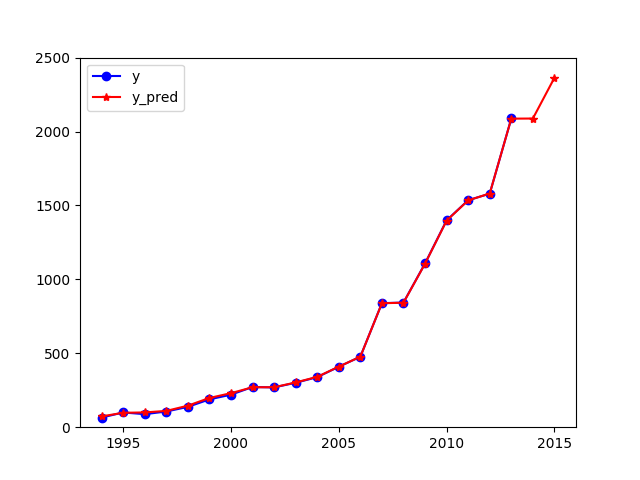

In [29]:
# 预测，并还原结果
x = ((data2[feature] - mean[feature]) / std[feature]).values
data2['y_pred'] = model.predict(x) * std['y'] + mean['y']
data2.to_excel(outputfile2)

import matplotlib.pyplot as plt
%matplotlib notebook
p = data2[['y', 'y_pred']].plot(style=['b-o', 'r-*'])
p.set_ylim(0, 2500)
p.set_xlim(1993, 2016)
plt.show()